## Importando recursos

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
import gensim
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Coleta dos dados

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv', encoding='ISO-8859-1', sep=',' )

df = df.head(500)

In [10]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Análise Exploratória

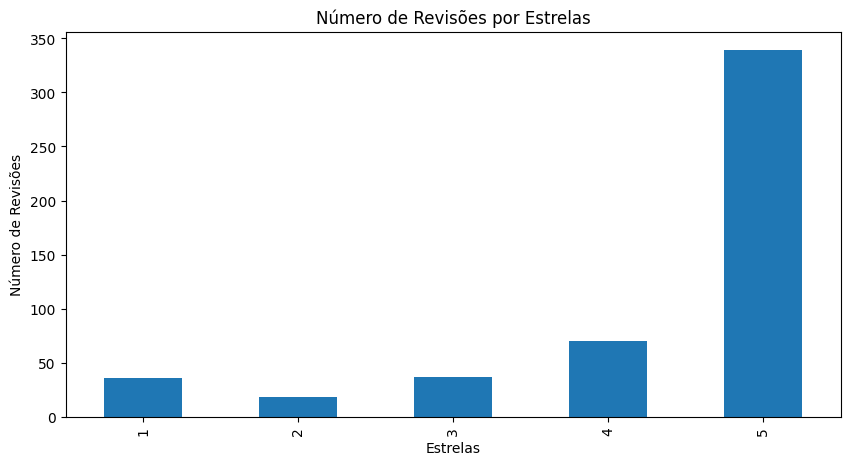

In [11]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Número de Revisões por Estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
ax.set_ylabel('Número de Revisões')
plt.show()

Análise de Sentimentos

In [12]:
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('words')
nltk.download('maxent_ne_chunker_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [13]:
text = df['Text'][24]
print(text)

I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now.


In [14]:
tokens = nltk.word_tokenize(text)

tokens[:10]

['I', 'have', 'lived', 'out', 'of', 'the', 'US', 'for', 'over', '7']

In [15]:
tagged = nltk.pos_tag(tokens)

tagged[:10]

[('I', 'PRP'),
 ('have', 'VBP'),
 ('lived', 'VBN'),
 ('out', 'IN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('US', 'NNP'),
 ('for', 'IN'),
 ('over', 'IN'),
 ('7', 'CD')]

In [16]:
entities = nltk.chunk.ne_chunk(tagged)

entities.pprint()

(S
  I/PRP
  have/VBP
  lived/VBN
  out/IN
  of/IN
  the/DT
  (ORGANIZATION US/NNP)
  for/IN
  over/IN
  7/CD
  yrs/NNS
  now/RB
  ,/,
  and/CC
  I/PRP
  so/RB
  miss/JJ
  my/PRP$
  Twizzlers/NNS
  !/.
  !/.
  When/WRB
  I/PRP
  go/VBP
  back/RB
  to/TO
  visit/NN
  or/CC
  someone/NN
  visits/NNS
  me/PRP
  ,/,
  I/PRP
  always/RB
  stock/NN
  up/RP
  ./.
  All/DT
  I/PRP
  can/MD
  say/VB
  is/VBZ
  (ORGANIZATION YUM/JJ)
  !/.
  </JJ
  br/NN
  //NNP
  >/NNP
  Sell/NNP
  these/DT
  in/IN
  (GPE Mexico/NNP)
  and/CC
  you/PRP
  will/MD
  have/VB
  a/DT
  faithful/JJ
  buyer/NN
  ,/,
  more/RBR
  often/RB
  than/IN
  I/PRP
  'm/VBP
  able/JJ
  to/TO
  buy/VB
  them/PRP
  right/RB
  now/RB
  ./.)


# Aplicação de modelo RoBERTa

In [17]:
!pip install torch
!pip install tensorflow
!pip install flax
!pip install --upgrade tensorflow-intel
!pip install ml-dtypes==0.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.1/710.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.4/744.4 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1


In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [19]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer (example, return_tensors= 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores [0],
        'roberta_neu' : scores [1],
        'roberta_pos' : scores [2]
    }
    return (scores_dict)

In [20]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    my_id = row['Id']
    roberta_result = polarity_scores_roberta(text)
    res[my_id] = roberta_result
  except RuntimeError:
    print(f'id {i} falhou')

 17%|█▋        | 83/500 [01:31<01:25,  4.85it/s]

id 82 falhou


 38%|███▊      | 188/500 [02:13<01:09,  4.49it/s]

id 186 falhou


100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


In [21]:
results_df= pd.DataFrame(res).T
results_df= results_df.reset_index().rename(columns ={'index':'Id'})
results_df=results_df.merge(df, how='left')
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [22]:
results_df.columns

Index(['Id', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## avaliação de resultados

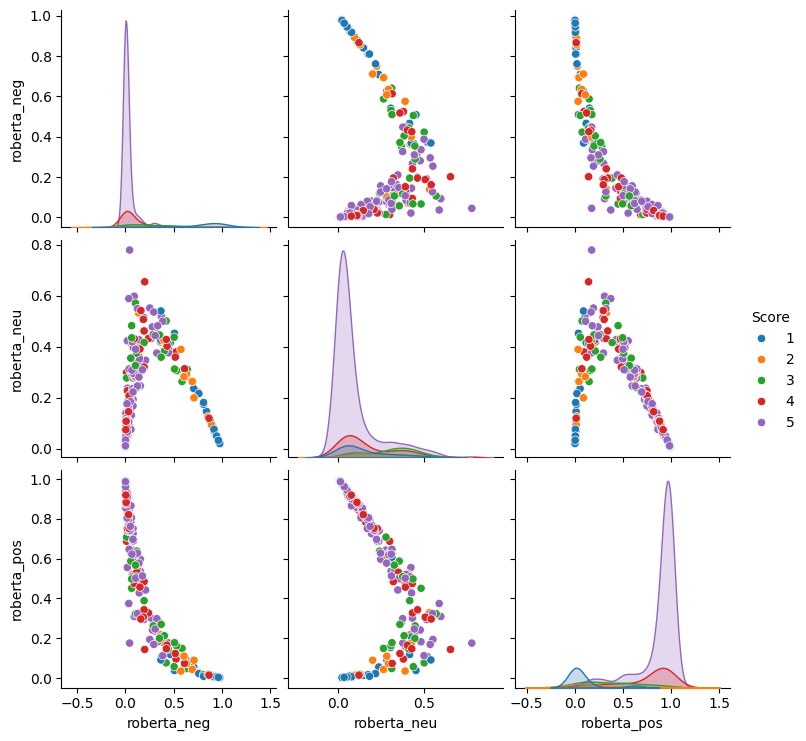

In [23]:
sns.pairplot (data = results_df, vars= ['roberta_neg', 'roberta_neu', 'roberta_pos'],
                    hue= 'Score', palette = 'tab10')
plt.show()

In [24]:
results_df.query('Score == 1').sort_values ('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [25]:
results_df.query('Score == 5').sort_values ('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Aplicação de modelo SVM

In [26]:
# Pré-processamento textual antes de treinar o modelo Word2Vec
from nltk.tokenize import word_tokenize
# tokenizador de sentença do nltk
nltk.download('punkt')

tokenized = [word_tokenize(i) for i in df['Text'].values]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized, vector_size=50, window=5, min_count=1, workers=4)

In [28]:
model.wv.most_similar('free')

[('in', 0.9977819919586182),
 ('she', 0.9977125525474548),
 ('a', 0.997677206993103),
 ('like', 0.9976639151573181),
 ('on', 0.9976279735565186),
 ('were', 0.9975712299346924),
 ('these', 0.9975581765174866),
 ('more', 0.997502326965332),
 ('your', 0.9974808096885681),
 (',', 0.997470498085022)]

# Definição de Pipeline

In [ ]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love you')

In [ ]:
sent_pipeline('I hate traffic')